# 주제: Word-Level로 번역기 업그레이드하기

## 데이터
영어와 프랑스어의 병렬 코퍼스  
상위 33,000개의 샘플만 사용  
출처: https://www.manythings.org/anki/  
## 목표
1. 구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행
2. seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행
3. 테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인

## (1) 라이브러리 및 데이터 불러오기

In [19]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
125437,Tom is always here on Mondays.,Tom est toujours là le lundi.,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
45207,Do you want an apple?,Veux-tu une pomme ?,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
166063,How did you come up with that answer?,Comment êtes-vous parvenu à cette réponse ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
92420,We agreed among ourselves.,Nous nous mîmes d'accord entre nous.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
72360,It was a trick question.,C'était une question piège.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


## (2) 데이터 전처리

In [3]:
# 3번째 열은 불필요하므로 제거
lines = lines[['eng', 'fra']][:33000] # 3만3천개 샘플 사용
lines.sample(5)

,eng,fra
31104,Do you like school?,Aimes-tu l'école ?
19714,I am pretty sure.,J’en suis plutôt sûre.
7132,Don't mock me.,Ne te moque pas de moi.
26232,I need to see you.,J'ai besoin de te voir.
7352,He's annoying.,Il est embêtant.


In [4]:
import re
sos_token = '<sos>'
eos_token = '<eos>'
    
# 입력된 문장 필터링
#     1. 소문자로 바꾸고, 양쪽 공백 지우기
#     2. 특수문자 양쪽에 공백 넣기
#     3. 여러개의 공백은 하나의 공백으로 바꾸기
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
#     5. 다시 양쪽 공백을 지우기
#     6. 디코더 앞 뒤에 시작토큰과 종료토큰 첨부하기
def preprocess_sentence(sentence, plus_token = True):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    if plus_token == True: #6
        sentence = sos_token + ' ' + sentence + ' ' + eos_token

    return sentence

In [5]:
eng_lines = []
fra_lines = []

for eng, fra in zip(lines.eng, lines.fra):
    if len(eng) == 0: continue
    if len(fra) == 0: continue   
        
    eng_lines.append(preprocess_sentence(eng, plus_token = False))
    fra_lines.append(preprocess_sentence(fra))

In [6]:
print(eng_lines[:5])
print(fra_lines[:5])

['go .', 'go .', 'go .', 'go .', 'hi .']
['<sos> va ! <eos>', '<sos> marche . <eos>', '<sos> en route ! <eos>', '<sos> bouge ! <eos>', '<sos> salut ! <eos>']


In [7]:
eng_tokenizer = Tokenizer(filters = ' ')   # 단어 단위로 Tokenizer를 생성
eng_tokenizer.fit_on_texts(eng_lines)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(eng_lines)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[27, 1], [27, 1], [27, 1]]

In [8]:
fra_tokenizer = Tokenizer(filters = ' ')   # 단어 단위로 Tokenizer를 생성 
fra_tokenizer.fit_on_texts(fra_lines)                 # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(fra_lines)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 73, 9, 2], [1, 341, 3, 2], [1, 27, 524, 9, 2]]

In [9]:
# 단어장 크기
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1

In [10]:
# 단어 시퀀스 최대 길이
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])

In [11]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4515
프랑스어 단어장의 크기 : 7264
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


## (3) 인코더, 디코더 만들기 

In [12]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [13]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 73, 9], [1, 341, 3], [1, 27, 524, 9]]
[[73, 9, 2], [341, 3, 2], [27, 524, 9, 2]]


In [14]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [15]:
print(encoder_input[0])

[27  1  0  0  0  0  0  0]


In [16]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))
# 샘플의 수 × 샘플의 길이 × 단어장의 크기

영어 데이터의 크기(shape) : (33000, 8, 4515)
프랑스어 입력데이터의 크기(shape) : (33000, 17, 7264)
프랑스어 출력데이터의 크기(shape) : (33000, 17, 7264)


## (4) 훈련데이터, 평가데이터 분리

In [17]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))
print('영어 훈련데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_test))

영어 학습데이터의 크기(shape) : (30000, 8, 4515)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 17, 7264)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 17, 7264)
영어 훈련데이터의 크기(shape) : (3000, 8, 4515)
프랑스어 학습 입력데이터의 크기(shape) : (3000, 17, 7264)
프랑스어 학습 출력데이터의 크기(shape) : (3000, 17, 7264)


## (5) 모델 구성-인코더, 디코더, 디코더 출력

In [20]:
embedding_size = 512
hidden_size = 512
# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size,
                    input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout = 0.5, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

In [21]:
# 디코더
decoder_inputs = Input(shape=(None, ), name='decoder_input')
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout = 0.5, return_sequences = True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)

In [22]:
# 디코더 출력
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [23]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    2311680     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 512)    3719168     decoder_input[0][0]              
______________________________________________________________________________________________

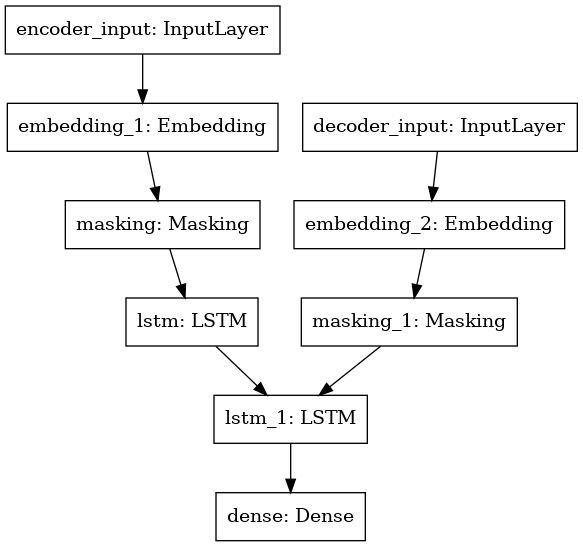

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model)

## (6) 학습하기

In [ ]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=32, epochs=10)

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,8))

# loss 그래프
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (7) 모델 테스트하기

In [ ]:
# 인코더 그대로 사용
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

In [ ]:
# 디코더 새롭게 변화
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]

In [ ]:
# 디코더 출력층
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

In [ ]:
# 이미 존재하는 사전
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['\t']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [ ]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [ ]:
# 출력결과 테스트
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # <sos>와 <eos> 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # <eos> 빼고 출력

->

# 프로젝트 회고

## 배운점
1. 토큰화할 때 크게 Word-based Tokenization, Character-based Tokenization,Subword Tokenization 이렇게 3가지로 분류된다는 것을 알 수 있었다. 최근엔 Subword를 이용하는 사례가 늘어나고 있다는데 이 방법으로도 시도해보고 싶다.
2. 모델 구성이 잘못되더라도 모델 구성 단계에서는 오류가 뜨지 않다가 모델 학습 단계에서 커널이 임의로 죽는 현상을 발견하였다. 따라서 매번 코드블럭을 작성할 때마다 더 세심하게 봐야겠다는 생각이 들었다. 

## 아쉬운점

## 종합의견


# Reference
1. 토큰화  
https://wikidocs.net/166796  
2. 정수 인코딩  
https://wikidocs.net/31766  
3. 케라스 임베딩층  
https://wikidocs.net/33793  